In [111]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from tqdm import tqdm
from sklearn import preprocessing
import talib

sys.path.append('../Runs')
from train_QTable import optimal_strategy, optimal_strategy_fixedStepsize, run
from train_fromSamples import train_BatchTree_fromSamples, train_Qtable_fromSamples
from helper.Q_learning import round_custombase
from helper.manage_orderbooks import OrderbookEpisodesGenerator, plot_episode, convert_actions_to_limit
from helper.orderbook_trader import OrderbookTradingSimulator
from agents.QTable_Agent import QTable_Agent
from agents.BatchTree_Agent import RLAgent_BatchTree

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def load_and_preprocess_historyfiles(files):
    hist = pd.DataFrame()
    for file in histfiles:
        data = pd.read_csv(file, index_col=0)
        hist = pd.concat([hist, data])
    hist.set_index(keys=pd.to_datetime(hist.index), inplace=True)

    # remove dublicates and unneeded columns
    hist = hist[~hist.index.duplicated(keep='first')]
    hist.drop(["id", 'isFrozen'], axis=1, inplace=True)

    # fill gaps with last observation
    idx = pd.date_range(hist.index[0], hist.index[-1], freq="1min")
    hist = hist.sort_index().reindex(index=idx.sort_values(), method='ffill')
    
    # add more features
    hist['spread'] = hist.lowestAsk - hist.highestBid

    for lookahead in [15, 30, 45]:
        hist["future{}".format(lookahead)] = (hist['last'].shift(-lookahead) / hist['last']) - 1.

    return hist

histfiles = [
    "../../../../data/history/history_2016-11_USDT_BTC.csv",
    "../../../../data/history/history_2017-02_USDT_BTC.csv",
]

hist = load_and_preprocess_historyfiles(files=histfiles)
hist['future15_disc'] = pd.cut(hist.future15, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
hist['future30_disc'] = pd.cut(hist.future30, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
hist['future45_disc'] = pd.cut(hist.future45, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
display(hist.iloc[1021:1025,:])

,baseVolume,high24hr,highestBid,last,low24hr,lowestAsk,percentChange,quoteVolume,spread,future15,future30,future45,future15_disc,future30_disc,future45_disc
2016-11-09 03:01:00,417050.045093,716.0,709.740242,709.740241,702.680396,711.419498,0.004009,586.622061,1.679256,0.002366,0.004593,0.013399,3.0,3.0,4.0
2016-11-09 03:02:00,417128.134302,716.0,709.768994,711.419498,702.680396,711.419498,0.006251,586.731342,1.650504,0.002019,0.003802,0.008926,3.0,3.0,4.0
2016-11-09 03:03:00,417086.272705,716.0,709.723616,711.419498,702.680396,711.419498,0.006251,586.672174,1.695882,0.002019,0.003802,0.010514,3.0,3.0,4.0
2016-11-09 03:04:00,417050.431869,716.0,710.000001,710.000000,702.680396,711.419498,0.003144,586.621473,1.419497,0.003122,0.005845,0.013099,3.0,4.0,4.0


In [4]:
data_nov_orig = pickle.load( open( "cached_windows/tradingwindows_1611_USTD_BTC_20.p", "rb" ) )
for window in data_nov_orig:
    for ob in window:
        ob.norm_factor = 1.
        ob.features = {'spread': ob.asks.index[0]-ob.bids.index[0]}
        
        ts = pd.to_datetime(ob.timestamp)        
        ts_prev = pd.to_datetime(ob.timestamp) - pd.Timedelta('60Min')

        market_features = hist.loc[ts_prev:ts, :]
        
        for lookahead in [15,30,45]:
            ob.features["future{}".format(lookahead)] = market_features['future{}'.format(lookahead)][-1]
            ob.features["future{}_disc".format(lookahead)] = market_features['future{}_disc'.format(lookahead)][-1]
display(len(data_nov_orig), data_nov_orig[0][0])

20

OrderbookContainer from 2016-11-08T10:00 (factor: 1.0)
  107 bids (best: 705.0)
  110 asks (best: 705.450997)
price: 705.2254744655137
  kind: 'orderbook'
  -spread: 0.4509970000000294
  -future15: -3.246150348523713e-08
  -future15_disc: 2.0
  -future30: -0.0006393032568402512
  -future30_disc: 2.0
  -future45: -0.0025756666407984463
  -future45_disc: 1.0

In [5]:
data_feb = pickle.load( open( "cached_windows/tradingwindows_1702_USTD_BTC.p", "rb" ) )
print("loaded")
for window in tqdm(data_feb[:20]):
    for ob in window:
        ob.norm_factor = 1.
        ob.features = {'spread': ob.asks.index[0]-ob.bids.index[0]}
        
        ts = pd.to_datetime(ob.timestamp)        
        ts_prev = pd.to_datetime(ob.timestamp) - pd.Timedelta('60Min')

        market_features = hist.loc[ts_prev:ts, :]
        
        for lookahead in [15,30,45]:
            ob.features["future{}".format(lookahead)] = market_features['future{}'.format(lookahead)][-1]
            ob.features["future{}_disc".format(lookahead)] = market_features['future{}_disc'.format(lookahead)][-1]
display(len(data_feb), data_feb[0][0])

  5%|▌         | 1/20 [00:00<00:02,  6.67it/s]

loaded


100%|██████████| 20/20 [00:03<00:00,  6.07it/s]


670

OrderbookContainer from 2017-02-01T00:00 (factor: 1.0)
  139 bids (best: 965.8666755)
  113 asks (best: 965.99)
price: 965.928336437291
  kind: 'orderbook'
  -spread: 0.12332449999996697
  -future15: 0.001425825042782991
  -future15_disc: 3.0
  -future30: 0.002989831786579078
  -future30_disc: 3.0
  -future45: 0.00272120465321124
  -future45_disc: 3.0

In [53]:
data_selection = [data_nov_orig[x] for x in [0,17]]
print(len(data_selection))
print(data_selection[0][0].timestamp)
print(data_selection[1][0].timestamp)

2
2016-11-08T10:00
2016-11-09T03:01


In [116]:
convert_actions_to_limit(data_selection[0], actions=[1,2,3])

dp [0, 20, 40]
0 1000
20 1000
40 999


[705.93069993997915, 706.63592541444473, 706.63592541444473]

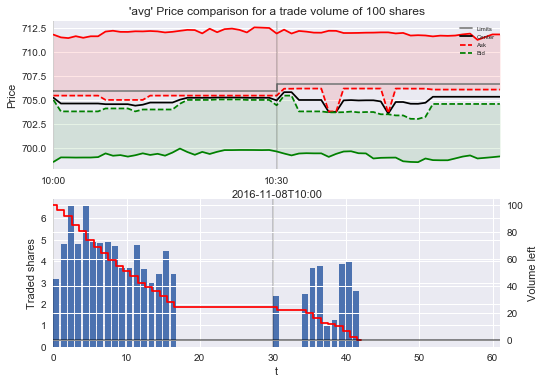

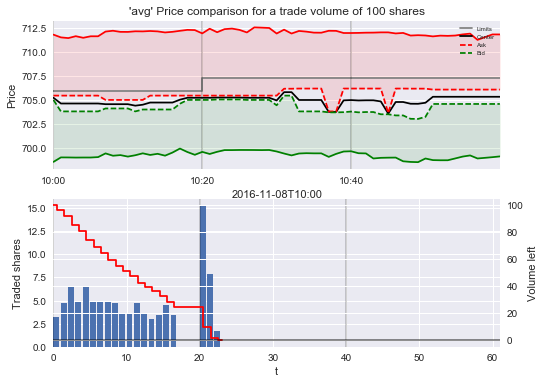

In [122]:
plot_episode(data_selection[0], actions=[1, 3])
plot_episode(data_selection[0], actions=[1, 3, 4])


2016-11-09 04:01:00 2016-11-09 04:00:00 0 days 00:01:00


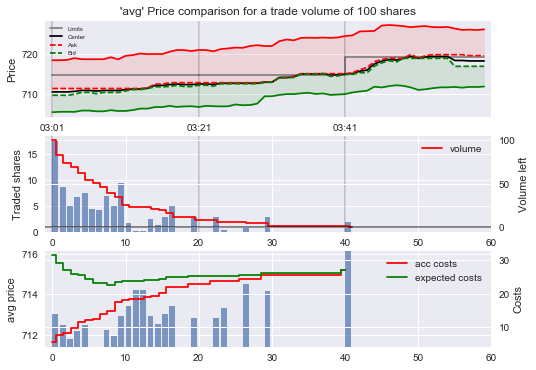

2016-11-09 04:01:00 2016-11-09 04:00:00 0 days 00:01:00


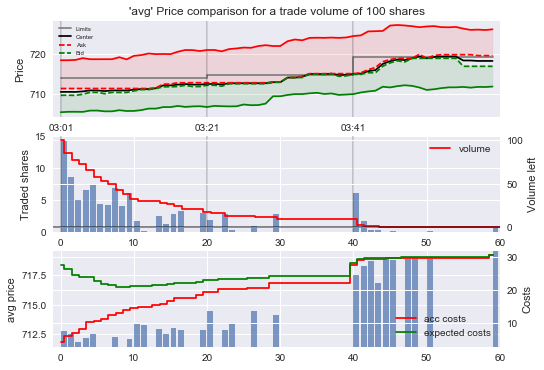

In [205]:
#plot_episode(data_selection[1], limits=[714.843016, 714.843016, 719.106494])
plot_episode(data_selection[1], actions=[6,4,6])
plot_episode(data_selection[1], actions=[5,4,6])


In [ ]:
experiment_name='individual_window'
folder='experiments'
outputfile_agent=os.path.join(folder, experiment_name, 'model', experiment_name)
outputfile_agent='q.json'
outputfile_samples='q.csv'
volume=100
volume_intervals=10
decision_points=3
period_length=20
actions = list(range(-4,11))

state_variables=['volume','time']
limit_base = 'incStepUnits' # 'curr_ask', 'init_center', 'incStepUnits'

# crescending
episodes_train = data_nov_orig[17:18]
print(actions)
print("Window len", len(episodes_train), episodes_train[0][0].timestamp)
ql_cresc, limits = optimal_strategy_fixedStepsize(traingdata=episodes_train[:], V=volume, T=decision_points,
                              period_length=period_length, vol_intervals=volume_intervals,
                              actions=list(range(-4,11)), lim_stepsize=0.1, state_variables=state_variables, 
                              outfile_agent=outputfile_agent, outfile_samples=outputfile_samples,
                              limit_base=limit_base, interpolate_vol=False)

# # hlines = [episodes_train[0][0].get_center() + (a*0.710579539245) for a in range(-4,11)]
# # #plot_episode(episodes_train[0], vlines=[0,15,30,45], hlines=hlines)
# # plot_episode(episodes_train[0], vlines=[0,15,30,45], hlines=limits)
# # ql.heatmap_Q(show_minima_count=True)
# # 
# # 
# # # even
# episodes_train = data_nov_orig[0:1]
# print("Window len", len(episodes_train), episodes_train[0][0].timestamp)
# 
# ql_even, limits_even = optimal_strategy_fixedStepsize(traingdata=episodes_train[:], V=volume, T=decision_points,
#                           period_length=period_length, vol_intervals=volume_intervals,
#                           actions=actions, lim_stepsize=0.1, state_variables=state_variables, 
#                           outfile_agent=outputfile_agent, outfile_samples=outputfile_samples,
#                           limit_base=limit_base, interpolate_vol=False)
# 
# episodes_train = data_selection
# print("Window len", len(episodes_train), episodes_train[0][0].timestamp)
# ql_both, limits_both = optimal_strategy_fixedStepsize(traingdata=episodes_train[:], V=volume, T=decision_points,
#                           period_length=period_length, vol_intervals=volume_intervals,
#                           actions=actions, lim_stepsize=0.1, state_variables=state_variables, 
#                           outfile_agent=outputfile_agent, outfile_samples=outputfile_samples,
#                           limit_base=limit_base, interpolate_vol=False)

In [ ]:
print(volume_intervals)
episodes_train = data_nov_orig
print("Window len", len(episodes_train), episodes_train[0][0].timestamp)
ql_20_cheat, limits_both = optimal_strategy_fixedStepsize(traingdata=episodes_train[:], V=volume, T=decision_points,
                          period_length=period_length, vol_intervals=volume_intervals,
                          actions=list(range(-4,11)), lim_stepsize=0.1, state_variables=state_variables + ['future15_disc'], 
                          outfile_agent=outputfile_agent, outfile_samples=outputfile_samples,
                          limit_base=limit_base, interpolate_vol=False)

In [ ]:
print(len(ql_cresc.q.keys()))
ql_cresc.heatmap_Q(show_minima_count=True)
print(len(ql_even.q.keys()))
ql_even.heatmap_Q(show_minima_count=True)
print(len(ql_both.q.keys()))
ql_both.heatmap_Q(show_minima_count=True)
print(len(ql_20.q.keys()))
ql_20.heatmap_Q(show_minima_count=True)

In [ ]:
print("### cresc ###")
result_cresc = ql['volInt_4'].evaluate(data_nov_orig[17:18],
            additional_agents=ql,
            evaluate_actions=range(-4,9),  # [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
            verbose=False)
display(result_cresc)

In [ ]:
print("### cresc ###")
result_cresc2 = ql_cresc.evaluate(data_selection[:2],
            evaluate_actions=range(-4,9),  # [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
            custom_strategies={'4,6,4': [4,6,4],
                               '5,6,4': [5,6,4],
                              '6,4,6': [6,4,6],
                              '6,5,6': [6,5,6],
                              '7,4,6': [7,4,6]},
            verbose=True,
            show_plot=True)
display(result_cresc)
display(result_cresc2)

# print("### even ###")
# results_even = ql_even.evaluate(data_nov_orig[0:1],
#             evaluate_actions=range(-4,9),  # [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
#             verbose=True)
# display(results_even)

In [ ]:
plot_episode(data_selection[1], limits=[714.843016, 714.843016, 719.106494])
#plot_episode(data_selection[1], limits=[715.553596])



In [ ]:
print("### both ###")
results_all = ql_both.evaluate(data_nov_orig[:],
            evaluate_actions=range(-1,9),  # [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
            additional_agents={'ql_cresc': ql_cresc,
                               'ql_even': ql_even,
                               'ql_20': ql_20,
                               'ql_20_cheat': ql_20_cheat,
                               'VolTime': agent_BatchTree['VolTime'],
                               'VolTimeFuturedisc15': agent_BatchTree['VolTimeFuturedisc15']},
            verbose=False,
           show_plot=True)
#display(results_all)

In [ ]:
print("### both ###")
results_all_feb = ql_both.evaluate(data_feb[:20],
            evaluate_actions=[6],  # [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
            additional_agents={'ql_cresc': ql_cresc,
                               'ql_even': ql_even,
                               'ql_20': ql_20,
                               'ql_20_cheat': ql_20_cheat,
                               'VolTime': agent_BatchTree['VolTime'],
                               'VolTimeFuturedisc15': agent_BatchTree['VolTimeFuturedisc15']},
            verbose=False,
           show_plot=True)
#display(results_all)

In [ ]:
df = ql_20.samples
def addMarketFeatures_toSamples(samples_df, hist, state_variables,
                                market_features, period_length=15):
    df = samples_df.copy()
    
    for i, f in tqdm(enumerate(market_features)):
        #
        f_n = "{}_n".format(f)
        if f in df.columns:
            df.drop(f, inplace=True, axis=1)
        if f_n in df.columns:
            df.drop(f_n, inplace=True, axis=1)
        
        df.insert(loc=2+i, column=f, value=df.timestamp.map(hist[f]),
                 allow_duplicates=True)
        df.insert(loc=df.shape[1],
                  column=f_n,
                  allow_duplicates=True,
                  value=(df.timestamp+pd.Timedelta(minutes=period_length)).map(hist[f]))
        if f not in state_variables:
            state_variables.append(f)

        if f in ['high24hr', 'low24hr', 'spread']:
            df[f] = df[f] / df.initial_center
            df[f_n] = df[f_n] / df.initial_center

    return df

df2 = addMarketFeatures_toSamples(samples_df=df, hist=hist, state_variables=state_variables,
                                 market_features=['future15', 'future15_disc', 'future30_disc', 'future45_disc'])
print(df2.shape)
display(df2.describe())

In [ ]:
actions = list(np.linspace(action_min, action_max, num=action_count))
actions = [round(a, 2) for a in actions]
print(actions)
state_variables = ['volume', 'time'] #, 'spread', 'high24hr', 'low24hr']

experiments = {
    'VolTime': ['volume', 'time'],
    # 'VolTimeSpread': ['volume', 'time', 'spread_disc'],
#    'VolTimeEMA': ['volume', 'time', 'EMA10', 'EMA60'],
    # 'VolTimeFuturedisc': ['volume', 'time', 'future15_disc', 'future30_disc', 'future45_disc']
    'VolTimeFuturedisc15': ['volume', 'time', 'future15_disc']
}

agent_BatchTree = {}
for i, key in enumerate(experiments.keys()):
    print("\n##### Experiment {}/{}: {} #####".format(i+1, len(experiments.keys()), key))
    state_variables_experiment = experiments[key]
    
    agent_BatchTree[key] = train_BatchTree_fromSamples(
        df=df2, V=volume, T=decision_points,
        period_length=period_length, vol_intervals=volume_intervals,
        actions=actions,
        state_variables=state_variables_experiment,
        n_estimators=100, max_depth=10
    )
    
    print("Feature importances:")
    print(agent_BatchTree[key].model.feature_importances_)

In [ ]:
plot_episode(episodes_train[1], vlines=[0,15,30,45], hlines=list(np.unique(limits)))

In [ ]:
plot_episode(episodes_train[1], vlines=[0,15,30,45], hlines=list(np.unique(limits)), limits=[episodes_train[1][0].get_center()*1.002])

In [ ]:
print("both")
ql.heatmap_Q(show_minima_count=True)
print("even")
ql_even.heatmap_Q(show_minima_count=True)
print("cresc")
ql_cresc.heatmap_Q(show_minima_count=True)



In [ ]:
agent_BatchTree['VolTime_20samples'].samples

In [ ]:
ql.limit_base = 'incStepUnits'
ql_even.limit_base = 'incStepUnits'
ql_cresc.limit_base = 'incStepUnits'
evaluation = ql.evaluate(data_nov[17:18],
                      additional_agents={
                          'ql_even': ql_even,
                          'ql_cresc':ql_cresc},
                      evaluate_actions=[0.4, 0.5, 0.6, 0.7, 0.8], verbose=True,
                      show_plot=True,
                      )
display(evaluation)
display(pd.DataFrame(evaluation.mean()).T)

In [ ]:
ql.volumes = ql.volumes[:4]
print(ql.volumes)

ql.heatmap_Q(vol_intervals=10)
ql.interpolate_vol = True
ql.heatmap_Q(vol_intervals=10)
ql.interpolate_vol = False

agent_BatchTree['VolTime_4I'].heatmap_Q()

In [ ]:
ql.interpolate_vol = True
evaluation = ql.evaluate(data_feb[:20],
                      additional_agents={
                          'rl_4I':agent_BatchTree['VolTime_4I'],
                          'rl_4I_3vars':agent_BatchTree['VolTime_4I_3vars']
                      },
                      evaluate_actions=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], verbose=False)
display(evaluation)
display(pd.DataFrame(evaluation.mean()).T)

In [ ]:
ql.interpolate_vol = False
evaluation = ql.evaluate(data_feb[:20],
                      additional_agents={
                          'rl_4I':agent_BatchTree['VolTime_4I'],
                          'rl_4I_3vars':agent_BatchTree['VolTime_4I_3vars']
                      },
                      evaluate_actions=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], 
                      verbose=False)
#display(evaluation)
display(pd.DataFrame(evaluation.mean()).T)

In [ ]:
display((evaluation / 52.069724).mean())
ql.plot_evaluation_costs(evaluation.iloc[10:,:], hline='0.4', showfliers=False, ylim=(0,80))

In [ ]:
#df2 = ql.samples
actions = list(np.linspace(action_min, action_max, num=action_count))
actions = [round(a, 2) for a in actions]
print(actions)
state_variables = ['volume', 'time'] #, 'spread', 'high24hr', 'low24hr']

experiments = {
    'VolTime_4I': ['volume', 'time'],
    'VolTime_4I_3vars': ['volume', 'time', 'future15_disc'],
    # 'VolTimeSpread': ['volume', 'time', 'spread_disc'],
#    'VolTimeEMA': ['volume', 'time', 'EMA10', 'EMA60'],
    # 'VolTimeFuturedisc': ['volume', 'time', 'future15_disc', 'future30_disc', 'future45_disc']
    #'VolTimeFuturedisc15_20samples': ['volume', 'time', 'future15_disc']
}

#agent_BatchTree = {}
for i, key in enumerate(experiments.keys()):
    print("\n##### Experiment {}/{}: {} #####".format(i+1, len(experiments.keys()), key))
    state_variables_experiment = experiments[key]
    
    agent_BatchTree[key] = train_BatchTree_fromSamples(
        df=df2, V=volume, T=decision_points,
        period_length=period_length, vol_intervals=volume_intervals,
        actions=actions,
        state_variables=state_variables_experiment,
        n_estimators=100, max_depth=10
    )
    
    print("Feature importances:")
    print(agent_BatchTree[key].model.feature_importances_)

In [ ]:
plot_episode(data_nov_orig[0], kind='worst')
plot_episode(data_nov_orig[0], kind='avg')
plot_episode(data_nov_orig[17], kind='worst')
plot_episode(data_nov_orig[17], kind='avg')

# plot_episode(data_nov_orig[17], limits=[1.003992, 1.006207, 1.009890, np.nan], intervals=4, kind='worst')
# plot_episode(data_nov_orig[17], limits=[1.003992, 1.006207, 1.009890, np.nan], intervals=4, kind='avg')
# plot_episode(data_nov_orig[17], limits=[1.005], intervals=4)
# #plot_episode(data_nov[17], limits=[1.005, 1.005, 1.005, 1.005], intervals=4)

In [ ]:
ql17_60decisions.limit_base = 'init_center'
ql17_60decisions.heatmap_Q()
display(ql17_60decisions.evaluate(data_nov[17:18]))
ql17_60decisions.limit_base = 'curr_ask'
display(ql17_60decisions.evaluate(data_nov[17:18]))

ql17.heatmap_Q()
display(ql17.evaluate(data_nov[17:18]), limit_base='curr_ask')

In [ ]:
for val in ql17_spread.samples.spread.unique():
    print("{:1.6f}".format(val))

In [ ]:
agent = ql17
display(agent.samples.shape, agent.samples.iloc[302:315,:])
agent.heatmap_Q()

agent = ql17_
display(agent.samples.shape, agent.samples.iloc[302:315,:])
agent.heatmap_Q(show_minima_count=True)

agent = ql17_15decisions
display(agent.samples.shape, agent.samples.iloc[302:315,:])
agent.heatmap_Q(show_minima_count=True)

agent = ql17_60decisions
display(agent.samples.shape, agent.samples.iloc[302:315,:])
agent.heatmap_Q(show_minima_count=True)

In [ ]:
eval_costs = ql.evaluate(data_nov[17:18], additional_agents={'ql17_':ql17_, 'ql17_15decisions':ql17_15decisions}, show_plot=True)
display(eval_costs)
display(eval_costs.mean())

In [ ]:
def load_and_preprocess_historyfiles(files):
    hist = pd.DataFrame()
    for file in histfiles:
        data = pd.read_csv(file, index_col=0)
        hist = pd.concat([hist, data])
    hist.set_index(keys=pd.to_datetime(hist.index), inplace=True)

    # remove dublicates and unneeded columns
    hist = hist[~hist.index.duplicated(keep='first')]
    hist.drop(["id", 'isFrozen'], axis=1, inplace=True)

    # fill gaps with last observation
    idx = pd.date_range(hist.index[0], hist.index[-1], freq="1min")
    hist = hist.sort_index().reindex(index=idx.sort_values(), method='ffill')
    
    # add more features
    hist['spread'] = hist.lowestAsk - hist.highestBid

    for lookahead in [15, 30, 45]:
        hist["future{}".format(lookahead)] = (hist['last'].shift(-lookahead) / hist['last']) - 1

    return hist

histfiles = [
    "../../../../data/history/history_2016-11_USDT_BTC.csv",
    # "../../../../data/history/history_2016-12_USDT_BTC.csv",
    # "../../../../data/history/history_2017-01_USDT_BTC.csv",
    # "../../../../data/history/history_2017-02_USDT_BTC.csv"
]

hist = load_and_preprocess_historyfiles(files=histfiles)
display(hist.describe())
display(hist.head())

In [ ]:
state_variables = ['volume', 'time', 'spread', 'future15', 'future30', 'future45']
print("state_variables", state_variables)
# add features to orderbooks

for window in tqdm(data_nov):
    for ob_idx, ob in enumerate(window):
        ob.features = {}
        # queue.append(ob)
        # if len(queue) == period_length:
        #     
        #     diffs = list(map(lambda t: queue[t].compare_with(queue[t-1]), range(1,len(queue))))
        #     
        #     neg = np.array([d.asks[d.asks<0].sum() for d in diffs]).sum()
        #     pos = np.array([d.asks[d.asks>0].sum() for d in diffs]).sum()
        #     
        #     ob.features['act15neg'] = neg
        #     ob.features['act15pos'] = pos
        
        ts = pd.to_datetime(ob.timestamp)        
        ts_prev = pd.to_datetime(ob.timestamp) - pd.Timedelta('60Min')

        
        
        market_features = hist.loc[ts_prev:ts, :]

       
        for lookahead in [15,30,45]:
            ob.features["future{}".format(lookahead)] = market_features['future{}'.format(lookahead)][-1]
        
        for var in state_variables[2:]:
            ob.features[var] = market_features[var][-1]
            
print(data_nov[0][0])
print(data_nov[10][0])